In [2]:
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.integrate import odeint

In [9]:
def simple_plot(x, y, xlabel=None, ylabel=None, scatterplot=False, lineplot=True,
                params_dict={'figure.figsize': (20,8), 'font.size': 20, 'lines.linewidth': 5, 'lines.markersize': 15},
                xticks=None, yticks=None, rotation=0):
    if params_dict is not None:
        plt.rcParams.update(params_dict)
    plt.figure()
    sns.set_style("darkgrid")
    if lineplot: sns.lineplot(x=x, y=y)
    if scatterplot: sns.scatterplot(x=x, y=y)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None: plt.ylabel(ylabel)
    if xticks != None: plt.xticks(xticks, rotation=rotation)
    if yticks != None: plt.yticks(yticks) 
    if rotation != None: plt.xticks(rotation=rotation)
    plt.show()  


def multiplot(X, Y, xlabel=None, ylabel=None, labels=None, scatterplot=False, lineplot=True,
                params_dict={'figure.figsize': (20,8), 'font.size': 20, 'lines.linewidth': 5, 'lines.markersize': 15},
                xticks=None, yticks=None, rotation=0):
    if params_dict is not None:
        plt.rcParams.update(params_dict)
    plt.figure()
    sns.set_style("darkgrid")
    if lineplot: 
        for (x, y, label) in zip(X, Y, labels):
            sns.lineplot(x=x, y=y, label=label)
    if scatterplot: 
        for (x, y, label) in zip(X, Y, labels):
            sns.scatterplot(x=x, y=y)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None: plt.ylabel(ylabel)
    if xticks != None: plt.xticks(xticks, rotation=rotation)
    if yticks != None: plt.yticks(yticks) 
    if rotation != None: plt.xticks(rotation=rotation)
    plt.show()  

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('data/owid-covid-data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364168 entries, 0 to 364167
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    364168 non-null  object 
 1   continent                                   346837 non-null  object 
 2   location                                    364168 non-null  object 
 3   date                                        364168 non-null  object 
 4   total_cases                                 325996 non-null  float64
 5   new_cases                                   354444 non-null  float64
 6   new_cases_smoothed                          353185 non-null  float64
 7   total_deaths                                304322 non-null  float64
 8   new_deaths                                  354495 non-null  float64
 9   new_deaths_smoothed                         353265 non-null  float64
 

In [11]:
df = pd.read_csv('data/owid-covid-data.csv')
df = df.loc[df['location']=='Russia', ['date', 'total_cases', 'new_cases', 'total_deaths', 'reproduction_rate', 'population_density', 'population']]
df['date'] = df['date'].astype('datetime64[ns]')
df = df.dropna(subset=['reproduction_rate', 'total_deaths'])
df = df.reset_index(drop=True)

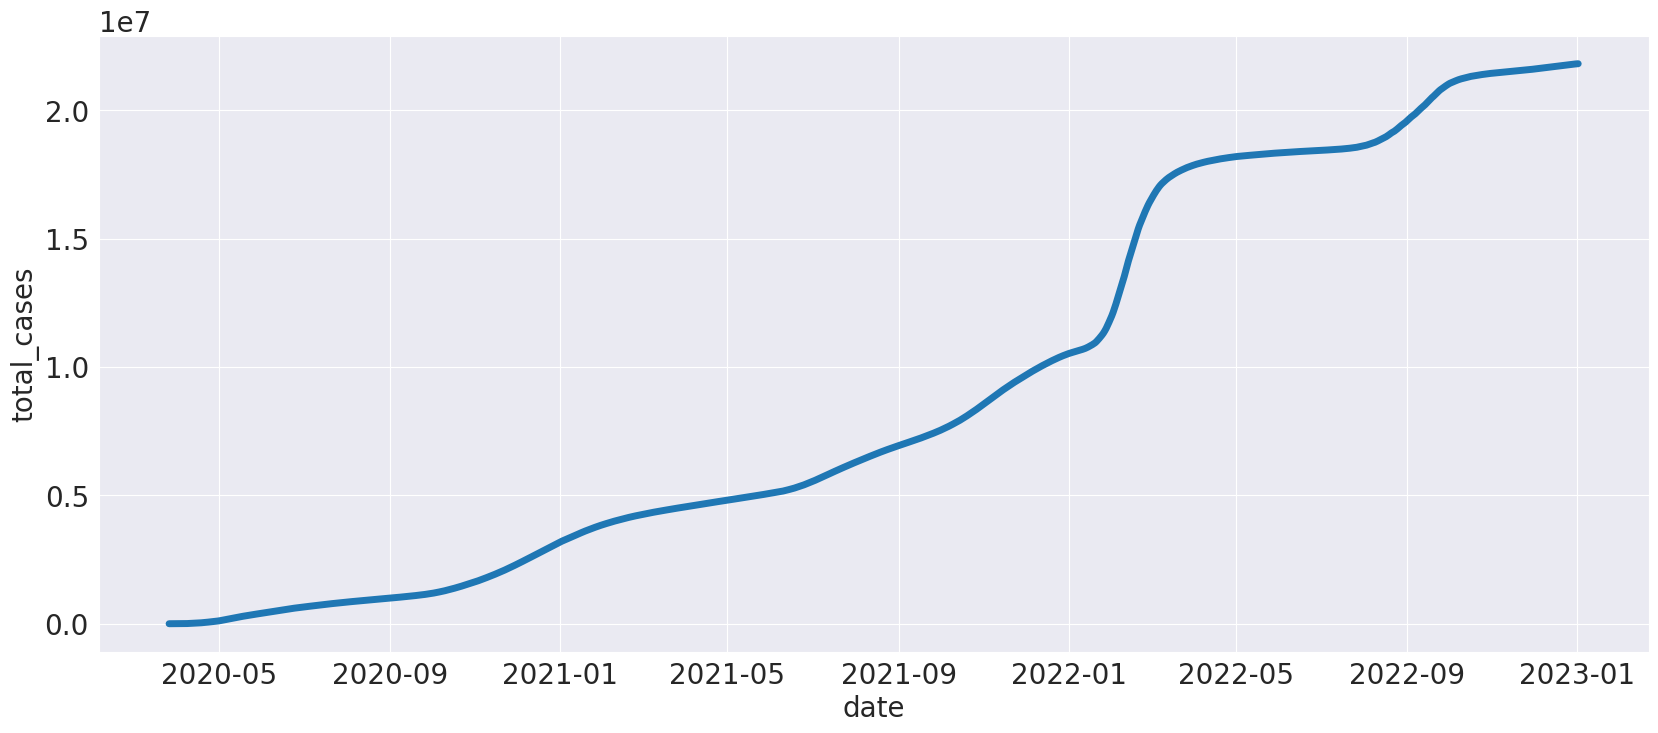

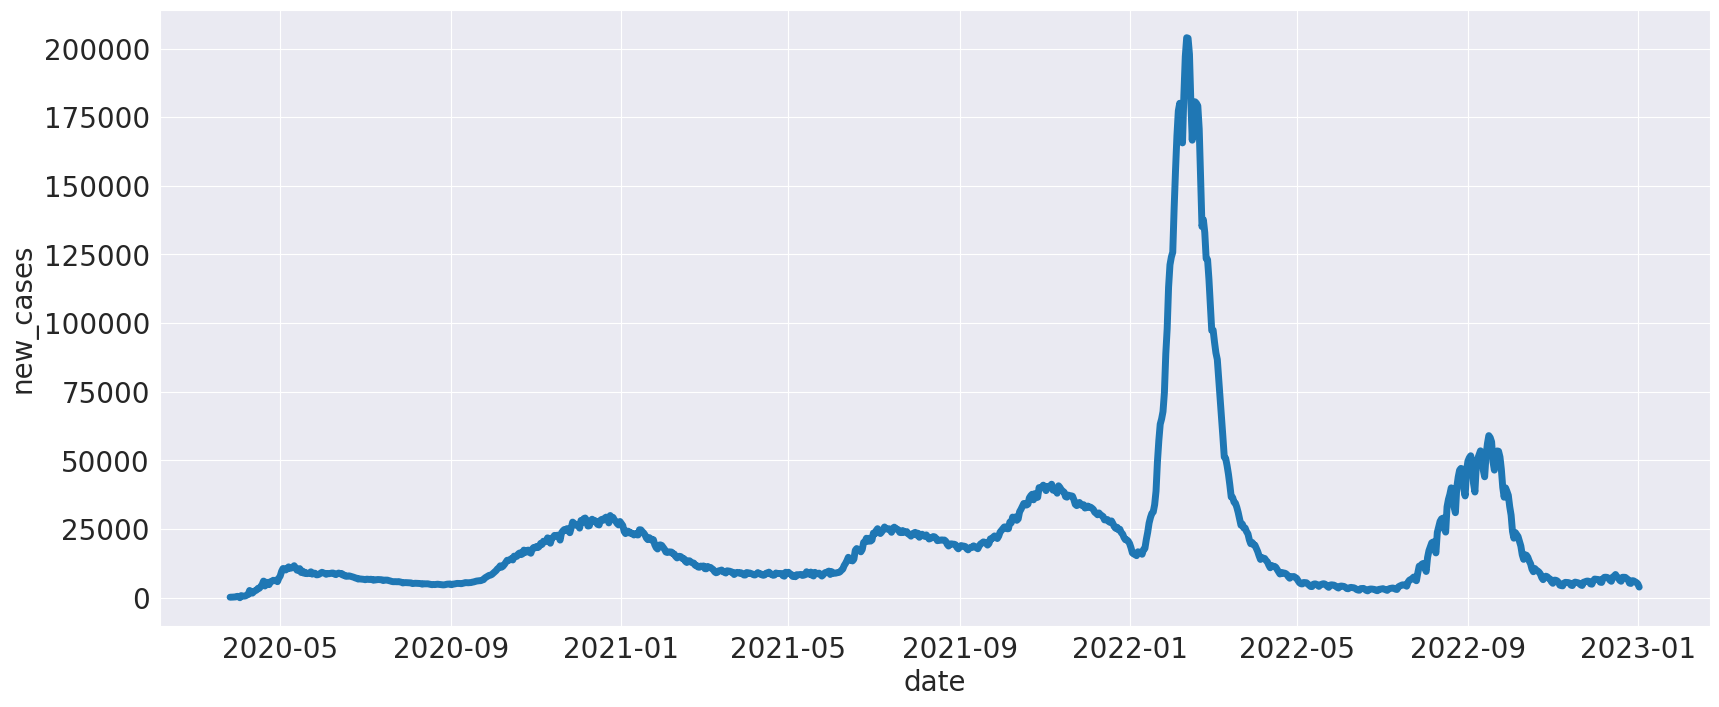

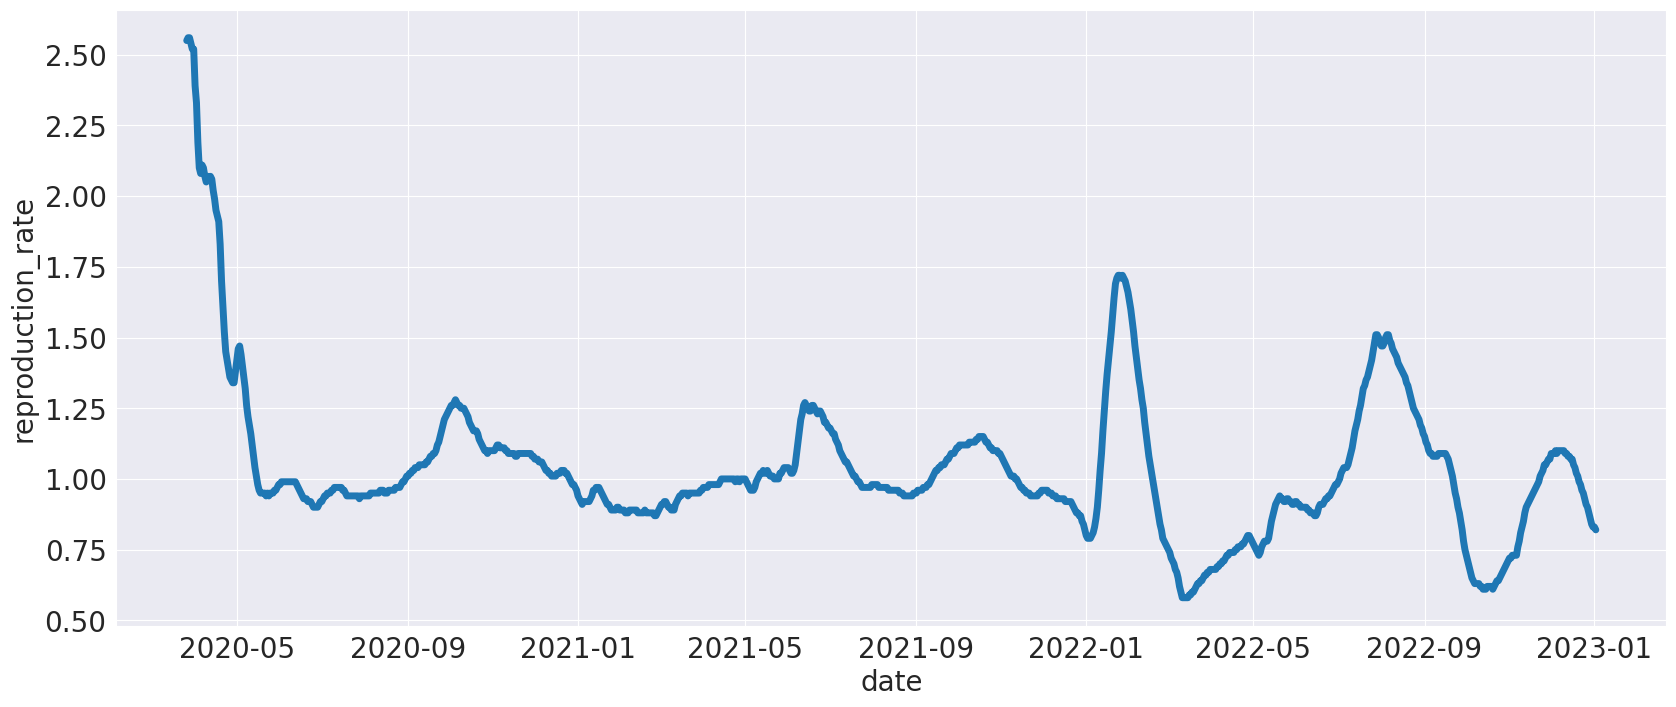

In [12]:
simple_plot(df['date'], df['total_cases'])
simple_plot(df['date'], df['new_cases'])
simple_plot(df['date'], df['reproduction_rate'])

In [6]:
df

,date,total_cases,total_deaths,reproduction_rate,population_density,population
0,2020-02-24,132.0,3.0,3.54,205.859,59037472.0
1,2020-02-25,229.0,7.0,3.50,205.859,59037472.0
2,2020-02-26,322.0,10.0,3.44,205.859,59037472.0
3,2020-02-27,400.0,12.0,3.36,205.859,59037472.0
4,2020-02-28,650.0,17.0,3.25,205.859,59037472.0
...,...,...,...,...,...,...
1039,2022-12-29,25119088.0,184528.0,1.30,205.859,59037472.0
1040,2022-12-30,25143705.0,184642.0,1.33,205.859,59037472.0
1041,2022-12-31,25168438.0,184792.0,1.32,205.859,59037472.0
1042,2023-01-01,25192831.0,184918.0,1.31,205.859,59037472.0


In [83]:
class SIR:

    def __init__(self, β, γ, σ):

        self.β = β
        self.γ = γ
        self.σ = σ

    
    def step(self, s1, x1, r1, d1, dt, N):

        s2 = s1 + dt * (-self.β*s1*x1/N)
        x2 = x1 + dt * (self.β*s1*x1/N - self.γ*x1 - self.σ*x1)
        r2 = r1 + dt * self.γ*x1
        d2 = d1 + dt * self.σ*x1

        return s1, x2, r2, d2


    def run(self, n_steps, x0, r0, d0, dt, N):

        S, X, R, D = [N], [x0], [r0], [d0]

        for step in range(n_steps):

            s, x, r, d = self.step(S[-1], X[-1], R[-1], D[-1], dt, N)
            S.append(s)
            X.append(x)
            R.append(r)
            D.append(d)

        return S, X, R, D

In [239]:
class SIR2:

    def __init__(self, γ, σ, N, R):

        self.R = R
        self.γ = γ
        self.σ = σ
        self.N = N

        self.k = 0


    def f(self, y, t):
        if t == 0:
            self.k = 0
        else:
            self.k += 1
        F = np.zeros(len(y))
        F[0] = -self.γ*self.R[self.k]*y[0]*y[1]/self.N
        F[1] = self.γ*self.R[self.k]*y[0]*y[1]/self.N - (self.γ + self.σ)*y[0]
        F[2] = self.γ*y[1]
        F[3] = self.σ*y[1]
        return F


def function(params, n):

    model = SIR2(*params, 60461826, df['reproduction_rate'])
    sol = odeint(model.f, [60461826, 132, 0, 0], np.arange(0, n))
    loss = np.sum((df['total_cases'][:n] - sol[:, 1])**2)
    
    return loss

In [240]:
init = np.random.uniform(0, 1, 2)
n = len(df)-2
result = optimize.minimize(function, init, method='Nelder-Mead', args=(n))
print(result['fun'] / function(init, n))
result

KeyError: 1044

In [212]:
class SEIR:

    def __init__(self, β, βF, τ, δ, κ, α, γ, C, N=60461826):

        self.β = β
        self.βF = βF
        self.τ = τ
        self.δ = δ
        self.κ = κ
        self.α = α
        self.γ = γ
        self.C = C
        self.N = N


    def f(self, y, t):

        F = np.zeros(len(y))
        F[0] = -self.β*y[2]*y[0]/self.N - self.βF*(1 - np.exp(-self.τ*self.C))*y[0]
        F[1] = (1 + self.δ)*self.β*y[2]*y[0]/self.N - self.κ*y[1]
        F[2] = self.κ*y[1] - self.α*y[2]
        F[3] = self.γ*self.C
        return F

In [213]:
def function(params, n):

    model = SEIR(*params)
    sol = odeint(model.f, [60461826, 60, 132, 4], np.arange(0, n))
    loss = np.sum((df['total_cases'][:n] - sol[:, -1])**2)
    
    return loss

In [214]:
init = np.random.uniform(0, 1, 8)
n = len(df)-1
result = optimize.minimize(function, init, method='Nelder-Mead', args=(n,))
print(result['fun'] / function(init, n))
result

/home/ubuntu/ContinuousMathematicalModelling/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/ubuntu/ContinuousMathematicalModelling/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3278342417447D+03   r2 =  0.4146152101129D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6348120250487D+03   r2 =  0.7808188728043D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2508865461470D+03   r2 =  0.2075107731664D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2999297634685D+03   r2 =  0.6957713242966D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      

/tmp/ipykernel_725/1499700647.py:19: RuntimeWarning: overflow encountered in scalar multiply
  F[0] = -self.β*y[2]*y[0]/self.N - self.βF*(1 - np.exp(-self.τ*self.C))*y[0]
/home/ubuntu/ContinuousMathematicalModelling/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3650000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646419160641D+03   r2 =  0.3646744155715D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3660000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646419160641D+03   r2 =  0.3646744155715D+03
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.3660000000000D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3680000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3676989617597D+03   r2 =  0.3677538208190D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3690000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3676989617597D+03   r2 =  0.3

/tmp/ipykernel_725/1499700647.py:21: RuntimeWarning: overflow encountered in scalar multiply
  F[2] = self.κ*y[1] - self.α*y[2]


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3650000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646821256314D+03   r2 =  0.3647234124422D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3660000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646821256314D+03   r2 =  0.3647234124422D+03
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.3660000000000D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3650000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646976123641D+03   r2 =  0.3647429213644D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3660000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3646976123641D+03   r2 =  0.3

/tmp/ipykernel_725/1499700647.py:20: RuntimeWarning: overflow encountered in scalar multiply
  F[1] = (1 + self.δ)*self.β*y[2]*y[0]/self.N - self.κ*y[1]


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3660000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3652783330535D+03   r2 =  0.3653250553160D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3670000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3652783330535D+03   r2 =  0.3653250553160D+03
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.3670000000000D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3660000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3651000397335D+03   r2 =  0.3651506436823D+03
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.3670000000000D+03
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.3651000397335D+03   r2 =  0.3

KeyboardInterrupt: 

In [215]:
model = SEIR(*np.random.uniform(0, 1, 8))
sol = odeint(model.f, [60461826, 60, 132, 4], np.arange(0, n))

In [112]:
def function(params, n = 100):

    model = SIR(*params)
    _, C, _, _, = model.run(n_steps=n, x0=132, r0=0, d0=0, N=60461826, dt=1)
    loss = (np.mean((df['total_cases'][:n+1] - C)**2))**(0.5)
    
    return loss

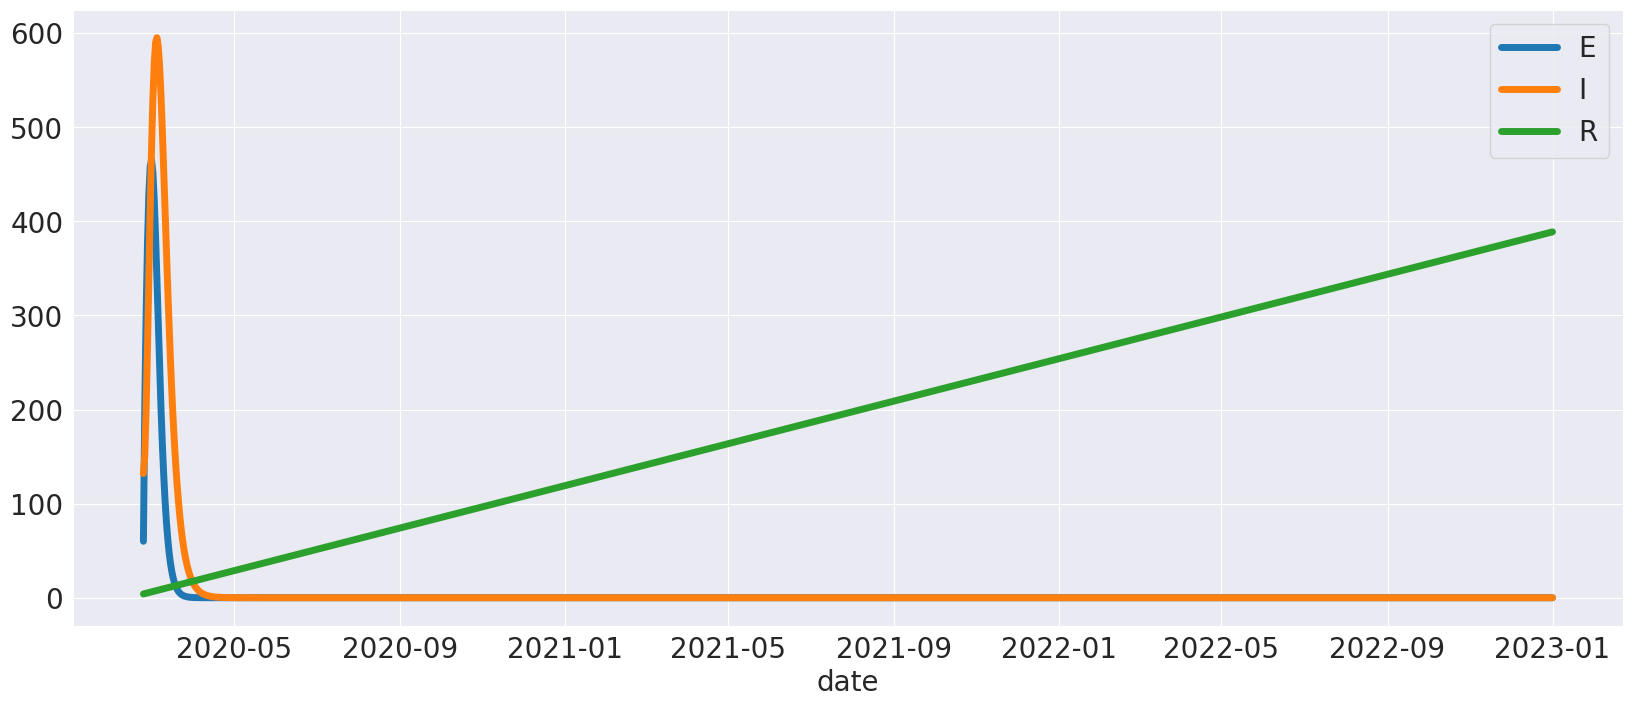

In [220]:
multiplot([df['date'][:n] for _ in range(3)], [sol[:, k] for k in range(1, 4)], labels=['E', 'I', 'R'])

In [219]:
init = np.random.uniform(0, 1, 3)
n = len(df)-1
result = optimize.minimize(function, init, method='Nelder-Mead', args=(n,))
print(result['fun'] / function(init, n))
result

TypeError: SEIR.__init__() missing 5 required positional arguments: 'δ', 'κ', 'α', 'γ', and 'C'

In [136]:
model = SIR(*result['x'])
_, C, _, _, = model.run(n_steps=n, x0=132, r0=0, d0=0, N=60461826, dt=1)

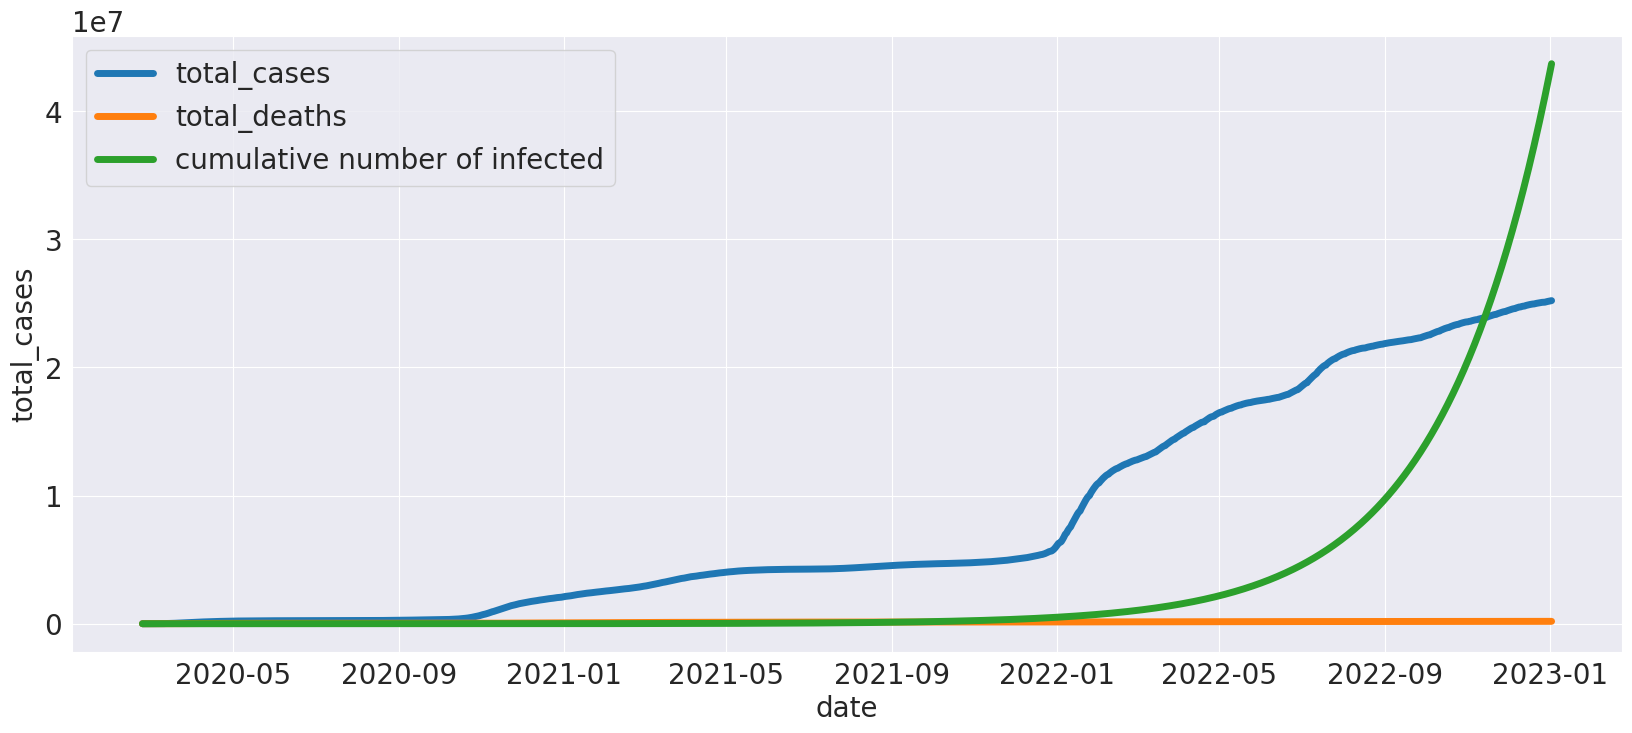

In [137]:
multiplot([df['date'][:n+1] for _ in range(3)], [df['total_cases'][:n+1], df['total_deaths'][:n+1], C], 
          labels=['total_cases', 'total_deaths', 'cumulative number of infected'])

In [180]:
class Covid22:

    def __init__(self, 
                 β1: float,
                 β2: float,
                 β3: float,
                 γ1: float,
                 γ2: float,
                 σ1: float,
                 σ2: float,
                 σ3: float,
                 δ: float,
                 a: float,
                 b: float,
                 A: float = 1224.,
                 µ: float = 0.010658,
                 d1: float = 0.18):
        """

        Parameters:
        - β1: Transmission rate of infection from I class
        - β2: Transmission rate of infection from E class
        - β3: Transmission rate of infection from Q class
        - µ: Normal death rate
        - γ1: Rate at which E class are quarantined
        - γ2: Rate at which E becomes infectious
        - σ1: Auto recovery rate of Q class
        - σ2: Auto recovery rate of E class
        - σ3: Auto recovery rate of I class
        - A: Recruitment rate
        - δ: Progression of Q class to I class after diagnosis
        - a: Cure rate of treatment
        - b: Delay parameter in treatment
        - d1: Disease induced death rate
        """

        self.β1 = β1
        self.β2 = β2
        self.β3 = β3
        self.µ = µ
        self.γ1 = γ1
        self.γ2 = γ2
        self.σ1 = σ1
        self.σ2 = σ2
        self.σ3 = σ3
        self.A = A
        self.δ = δ
        self.a = a
        self.b = b
        self.d1 = d1


    def f(self, y, t, N):

        y2 = np.zeros(len(y))
        y2[0] = self.A - (self.β1*y[0]*y[3] + self.β2*y[0]*y[1] + self.β3*y[0]*y[2])/N - self.µ*y[0]
        y2[1] = (self.β1*y[0]*y[3] + self.β2*y[0]*y[1] + self.β3*y[0]*y[2])/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*y[1]
        y2[2] = self.γ1*y[1] - (self.δ + self.σ1 + self.µ)*y[2]
        y2[3] = self.γ2*y[1] + self.δ*y[2] - (self.a*y[3])/(1 + self.b*y[3]) - (self.σ3 + self.d1 + self.µ)*y[3]
        y2[4] = self.σ1*y[2] + self.σ2*y[1] + self.σ3*y[3] + (self.a*y[3])/(1 + self.b*y[3]) - self.µ*y[4]
        y2[5] = self.γ2*y[1] + self.δ*y[2]
        # print(1 + self.b*I1)

        return y2
        
    
    def step(self, S1, E1, Q1, I1, R1, C1, N, dt):

        S2 = S1 + dt * (self.A - (self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - self.µ*S1)
        E2 = E1 + dt * ((self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*E1)
        Q2 = Q1 + dt * (self.γ1*E1 - (self.δ + self.σ1 + self.µ)*Q1)
        I2 = I1 + dt * (self.γ2*E1 + self.δ*Q1 - (self.a*I1)/(1 + self.b*I1) - (self.σ3 + self.d1 + self.µ)*I1)
        R2 = R1 + dt * (self.σ1*Q1 + self.σ2*E1 + self.σ3*I1 + (self.a*I1)/(1 + self.b*I1) - self.µ*R1)
        C2 = C1 + dt * (self.γ2*E1 + self.δ*Q1)
        # print(1 + self.b*I1)

        return S2, E2, Q2, I2, R2, C2


    def run(self, n_steps, S0, E0, Q0, I0, R0, N, dt):
        """
        Parameters:
        - n_steps (int): Number of timesteps
        - S0 (int): Initial number of susceptible people
        - E0 (int): Initial number of asymptomatic people
        - Q0 (int): Initial number of quarantined people
        - I0 (int): Initial number of infectious people (can cause the spread of infection)
        - R0 (int): Initial number of recovered people
        - N (int): Population size
        - dt (float): Time step size
        """

        S, E, Q, I, R = [S0], [E0], [Q0], [I0], [R0]
        C = [I0]

        for step in range(n_steps):

            s, e, q, i, r, c = self.step(S[-1], E[-1], Q[-1], I[-1], R[-1], C[-1], N, dt)
            
            S.append(s)
            E.append(e)
            Q.append(q)
            I.append(i)
            R.append(r)
            C.append(c)

        return np.array(S), np.array(E), np.array(Q), np.array(I), np.array(R), np.array(C)

In [196]:
def function(params, n):

    model = Covid22(*params)
    sol = odeint(model.f, [60461826, 0, 0, 132, 0, 132], np.arange(0, n), args=(60461826,))
    loss = np.sum((df['total_cases'][:n] - sol[:, -1])**2)
    
    return loss

In [197]:
sol = odeint(Covid22(*np.random.uniform(0, 1, 11)).f, [60461826, 0, 0, 132, 0, 132], np.arange(0, 100), args=(60461826,))

In [198]:
n = len(df) - 1
init = np.random.uniform(0, 1, 11)
result = optimize.minimize(function, init, method='Nelder-Mead', args=(n, ))
print(result['fun'] / function(init, n))
result

/home/ubuntu/ContinuousMathematicalModelling/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1030619174238D+04   r2 =  0.9324595872902D-09
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8699676842484D+03   r2 =  0.5971493281307D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9478633518350D+03   r2 =  0.3639257414545D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1038629809251D+04   r2 =  0.1366648971644D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      

/home/ubuntu/ContinuousMathematicalModelling/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9251858789503D+03   r2 =  0.2035289353427D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8474435072977D+03   r2 =  0.2590441560214D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8875264304781D+03   r2 =  0.3132985298422D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9179061791617D+03   r2 =  0.3408381533287D-07
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8850251656876D+

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 5.694081984245764e+16
             x: [ 6.561e-02  9.085e-01  2.315e-01  1.271e-01  1.421e+00
                  1.036e+00  1.267e+00 -2.629e-01  3.002e-02  3.991e-01
                  4.690e-02]
           nit: 1052
          nfev: 2200
 final_simplex: (array([[ 6.561e-02,  9.085e-01, ...,  3.991e-01,
                         4.690e-02],
                       [ 6.561e-02,  9.085e-01, ...,  3.991e-01,
                         4.690e-02],
                       ...,
                       [ 6.561e-02,  9.085e-01, ...,  3.991e-01,
                         4.690e-02],
                       [ 6.561e-02,  9.085e-01, ...,  3.991e-01,
                         4.690e-02]]), array([ 5.694e+16,  6.402e+16,  6.402e+16,  6.402e+16,
                        6.402e+16,  6.402e+16,  6.402e+16,  6.402e+16,
                        6.402e+16,  6.402e+16,  6.402e+16,  6.402e+1

In [200]:
sol = odeint(Covid22(*result['x']).f, [60461826, 0, 0, 132, 0, 132], np.arange(0, n), args=(60461826,))

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8875264304781D+03   r2 =  0.3132985298422D-07


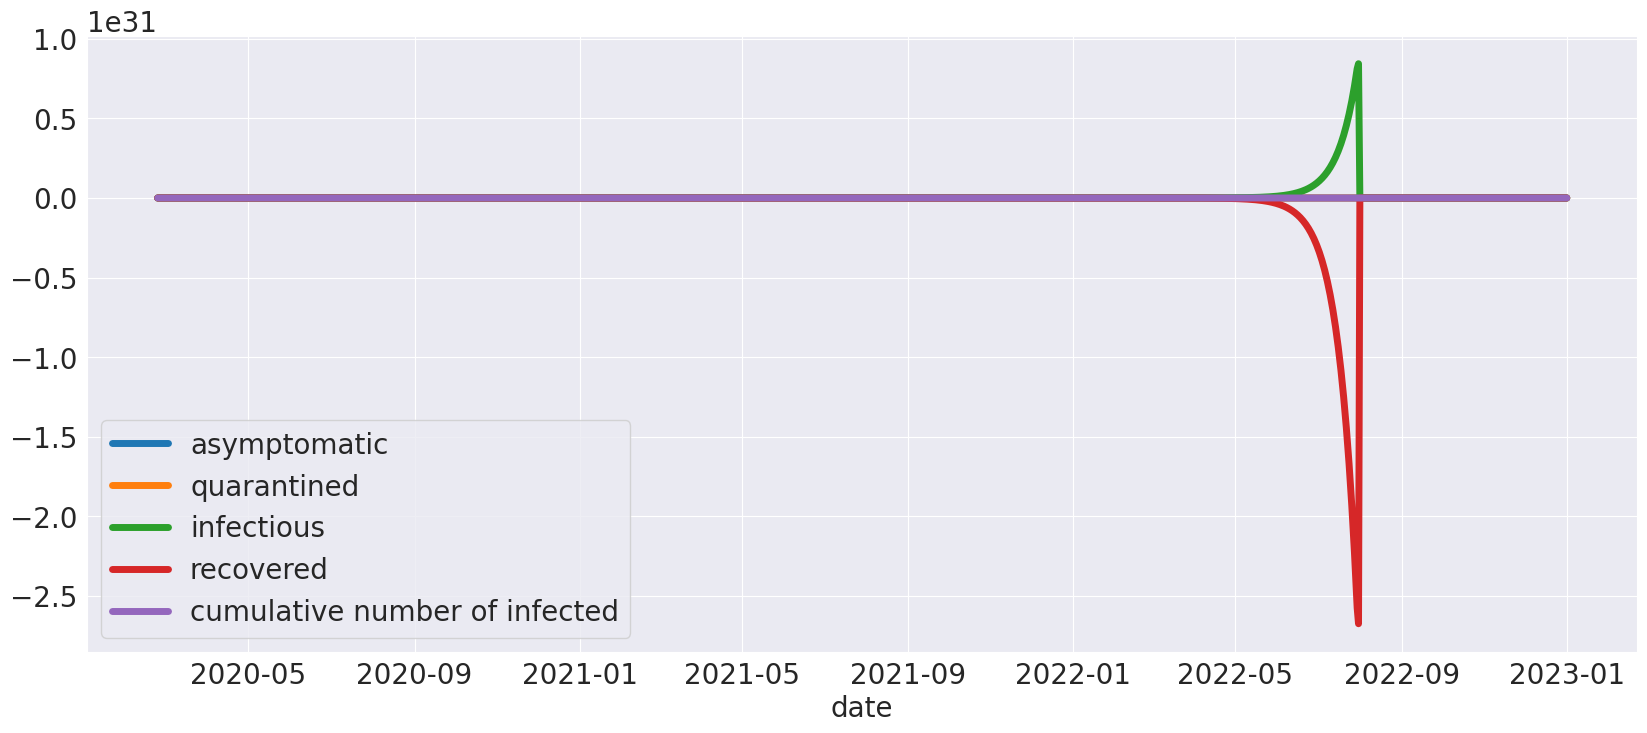

In [203]:
multiplot([df['date'][:n] for _ in range(5)], [sol[:, i] for i in range(1, 6)], 
          labels=['asymptomatic', 'quarantined', 'infectious','recovered', 'cumulative number of infected'])

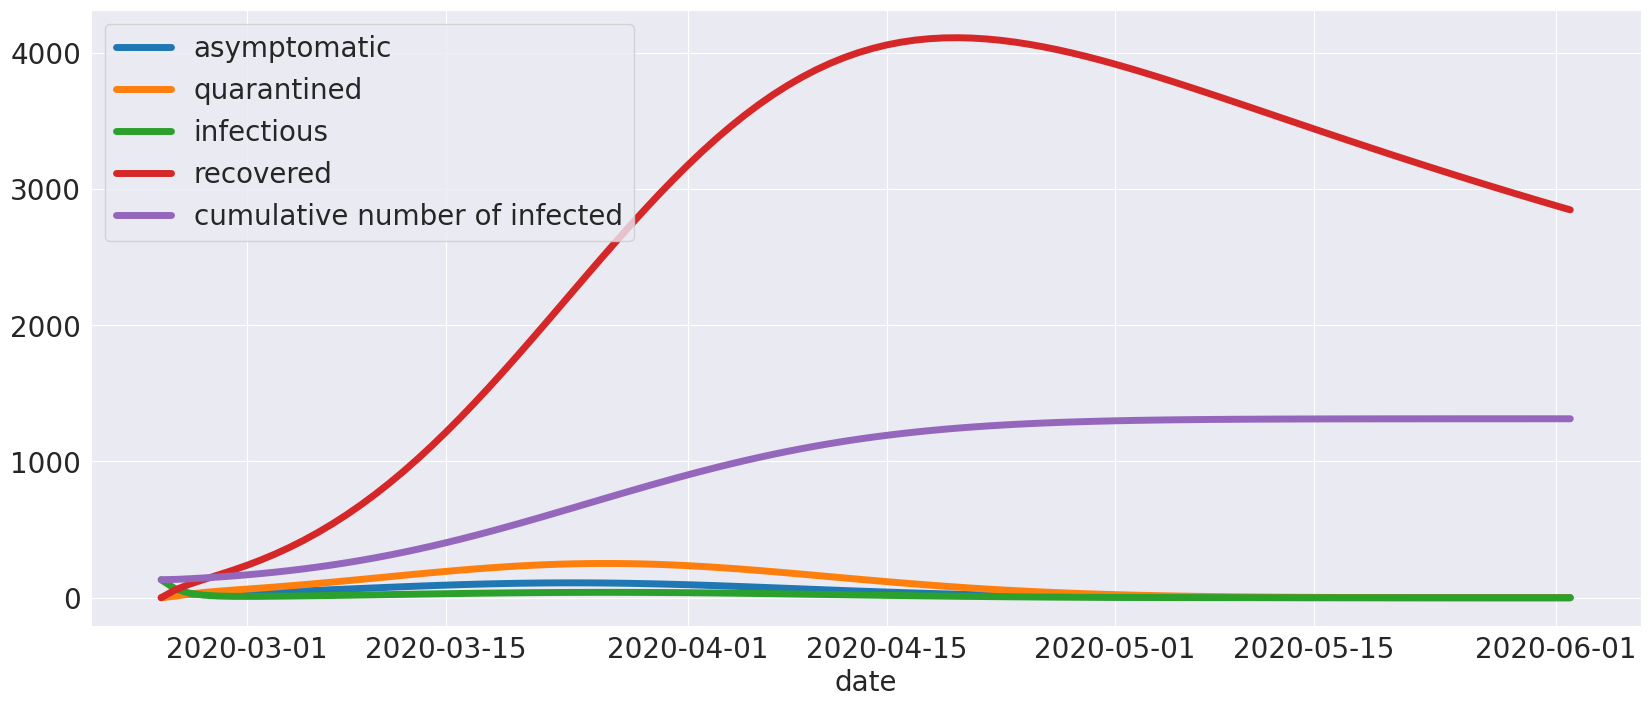

In [193]:
multiplot([df['date'][:100] for _ in range(5)], [sol[:, i] for i in range(1, 6)], 
          labels=['asymptomatic', 'quarantined', 'infectious','recovered', 'cumulative number of infected'])

In [179]:
n = len(df) - 1
init = np.random.uniform(0, 1, 11)
result = optimize.minimize(function, init, method='SLSQP', args=(n, ),
                           constraints=(
                               {'type':'ineq', 'fun': constraint2},
                          )
                          )
print(result['fun'] / function(init, n))
result

inf


/tmp/ipykernel_725/2575627527.py:55: RuntimeWarning: overflow encountered in scalar multiply
  S2 = S1 + dt * (self.A - (self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - self.µ*S1)
/tmp/ipykernel_725/2575627527.py:55: RuntimeWarning: invalid value encountered in scalar add
  S2 = S1 + dt * (self.A - (self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - self.µ*S1)
/tmp/ipykernel_725/2575627527.py:56: RuntimeWarning: overflow encountered in scalar multiply
  E2 = E1 + dt * ((self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*E1)
/tmp/ipykernel_725/2575627527.py:56: RuntimeWarning: invalid value encountered in scalar add
  E2 = E1 + dt * ((self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*E1)
/tmp/ipykernel_725/2575627527.py:58: RuntimeWarning: invalid value encountered in scalar divide
  I2 = I1 + dt * (self.γ2*E1 + self.δ*Q1 - (self.a*I1)/(1 + self.b*I1) - (self.σ3 + self.d1 + self.µ)*I1)
/tmp/ipykernel_725/2

 message: Singular matrix E in LSQ subproblem
 success: False
  status: 5
     fun: inf
       x: [ 9.105e+08  3.307e+07 -1.068e+09 -1.026e+07 -1.627e+09
           -1.195e+09  2.857e+08  2.150e+09  1.121e+08  7.366e+08
            1.162e+09]
     nit: 2
     jac: [       nan        nan        nan        nan        nan
                  nan        nan        nan        nan        nan
                  nan]
    nfev: 34
    njev: 2

In [66]:
params = {'β1': 0.951449, 'β2': 0.581276, 'β3': 0.865583, 'μ': 0.010658, 'γ1': 0.098267, 'γ2': 0.017199,
          'σ1': 0.053847, 'σ2': 0.01819, 'σ3': 0.123555, 'A': 1224, 'δ': 0.000168, 'a': 0.553732, 'b': 10.164964, 'd1': 0.18}

In [149]:
model = Covid22(*result['x'])
S, E, Q, I, R, C = model.run(n_steps=n, S0=60461826, E0=5, Q0=5, I0=132, R0=0, N=60461826, dt=1)

/tmp/ipykernel_725/616592207.py:55: RuntimeWarning: overflow encountered in scalar multiply
  S2 = S1 + dt * (self.A - (self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - self.µ*S1)
/tmp/ipykernel_725/616592207.py:56: RuntimeWarning: overflow encountered in scalar multiply
  E2 = E1 + dt * ((self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*E1)
/tmp/ipykernel_725/616592207.py:55: RuntimeWarning: invalid value encountered in scalar subtract
  S2 = S1 + dt * (self.A - (self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - self.µ*S1)
/tmp/ipykernel_725/616592207.py:56: RuntimeWarning: invalid value encountered in scalar subtract
  E2 = E1 + dt * ((self.β1*S1*I1 + self.β2*S1*E1 + self.β3*S1*Q1)/N - (self.γ1 + self.γ2 + self.σ2 + self.µ)*E1)
/tmp/ipykernel_725/616592207.py:58: RuntimeWarning: invalid value encountered in scalar divide
  I2 = I1 + dt * (self.γ2*E1 + self.δ*Q1 - (self.a*I1)/(1 + self.b*I1) - (self.σ3 + self.d1 + self.µ)*I1)
/tmp/ipykernel_

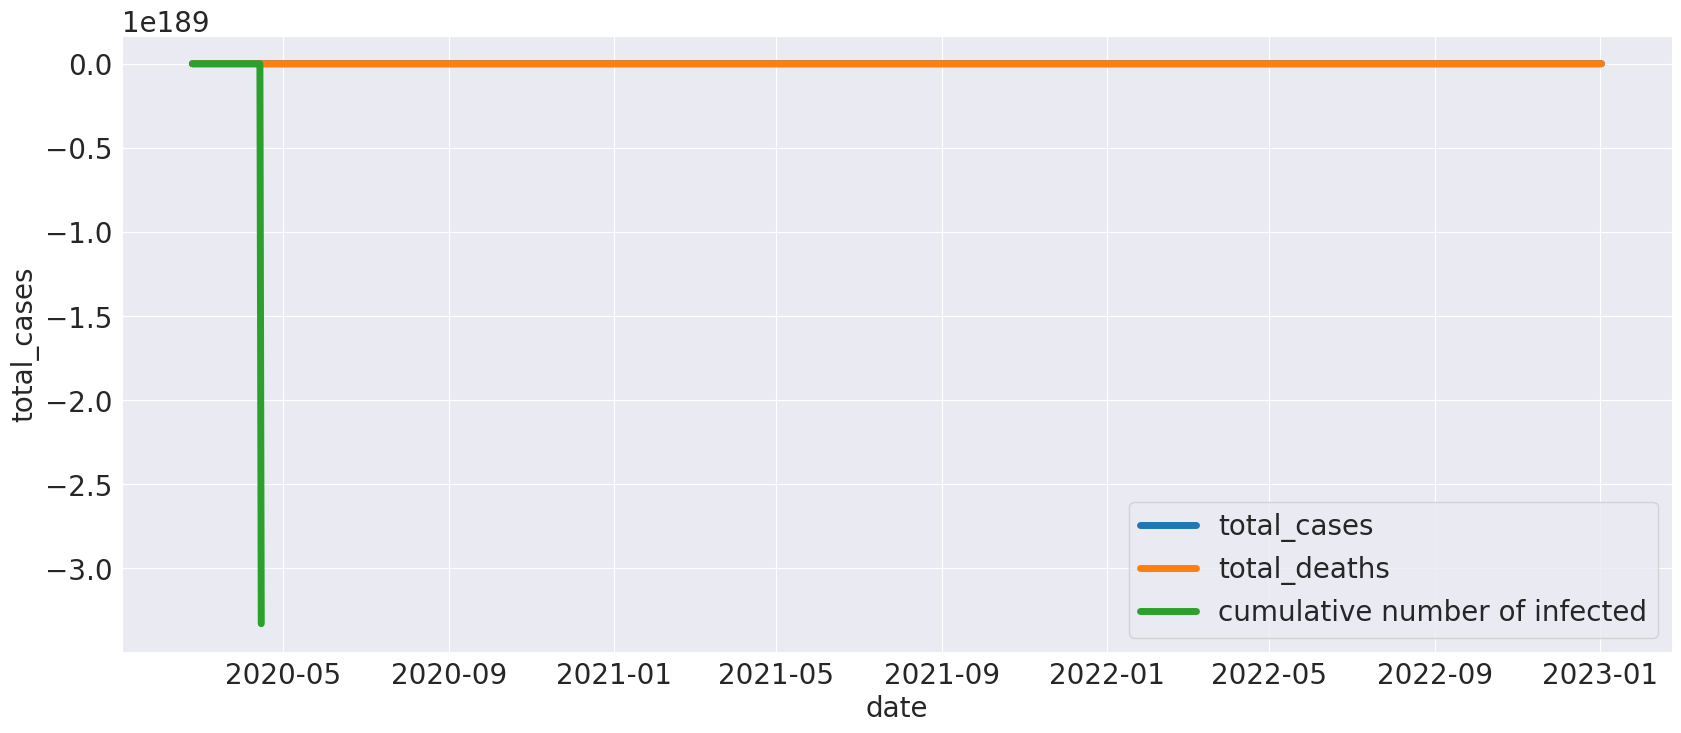

In [150]:
multiplot([df['date'][:n+1] for _ in range(3)], [df['total_cases'][:n+1], df['total_deaths'][:n+1], C], 
          labels=['total_cases', 'total_deaths', 'cumulative number of infected'])

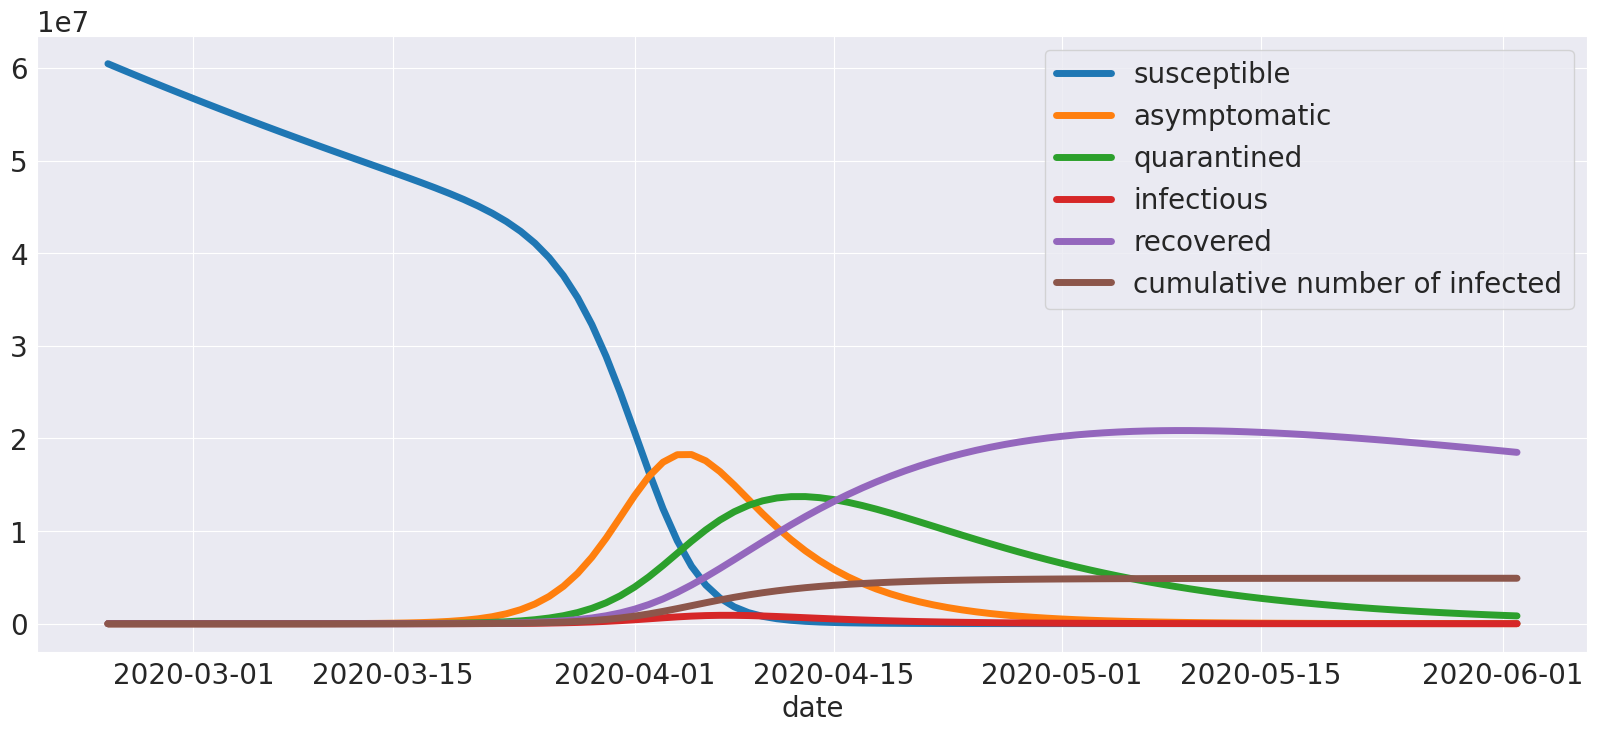

In [38]:
multiplot([df['date'][:100] for _ in range(6)], [S, E, Q, I, R, C], 
          labels=['susceptible', 'asymptomatic', 'quarantined', 'infectious','recovered', 'cumulative number of infected'])

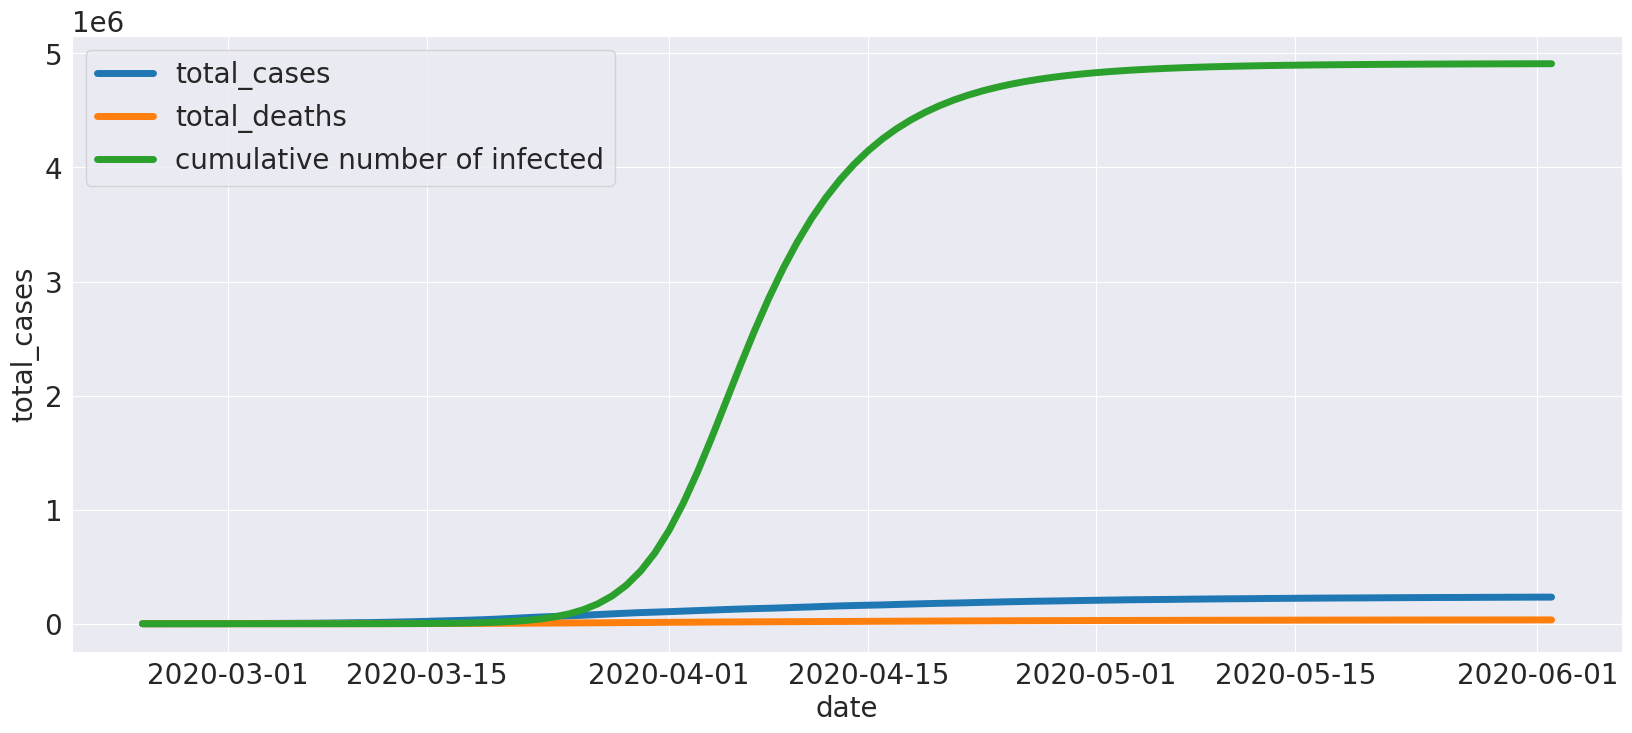

In [39]:
multiplot([df['date'][:100] for _ in range(3)], [df['total_cases'][:100], df['total_deaths'][:100], C], 
          labels=['total_cases', 'total_deaths', 'cumulative number of infected'])